In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics


# Ignore all warnings
warnings.filterwarnings('ignore')
# Set the maximum number of rows to display
pd.set_option('display.max_rows', None)


In [2]:
# Define a function to show values on bar charts
def show_values_on_bars(axs, space=0.4):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", va="bottom") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
# Load Data
data = pd.read_csv('vehicles.csv')

In [4]:
data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [5]:
# Determine and remove the columns to drop based on the above graph
cols_to_drop = ['id','url', 'region', 'region_url', 'VIN', 'image_url', 'description', \
    'county', 'size', 'paint_color', 'drive', 'cylinders', 'state', 'lat','long','title_status']
vehicles_df = data.drop(columns=cols_to_drop)

# Remove the larger data frame from memory
del data

# Get info of the new data frame
vehicles_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   fuel          423867 non-null  object 
 6   odometer      422480 non-null  float64
 7   transmission  424324 non-null  object 
 8   type          334022 non-null  object 
 9   posting_date  426812 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 32.6+ MB


In [6]:
# Initial cleaning up
# Drop NaNs and duplicates
vehicles_df.dropna(inplace=True)
vehicles_df.drop_duplicates(inplace=True)

# Update index and change data type of year to string
vehicles_df.index = range(len(vehicles_df))
vehicles_df.year = vehicles_df.year.astype(int).astype(str)


# Data Visualization & Cleaning
- Removed NaNs & duplicates

- Price b/w 2k and 50k

- Odometer b/w 100 and 200k, etc.

In [7]:
# Describing the dataset to get a basic idea of the non-categorical features
vehicles_df.describe()

,price,odometer
count,2.074940e+05,2.074940e+05
mean,4.399585e+04,9.139417e+04
std,8.576705e+06,1.914371e+05
min,0.000000e+00,0.000000e+00
25%,6.950000e+03,3.103300e+04
50%,1.559000e+04,7.818000e+04
75%,2.759000e+04,1.300000e+05
max,3.736929e+09,1.000000e+07


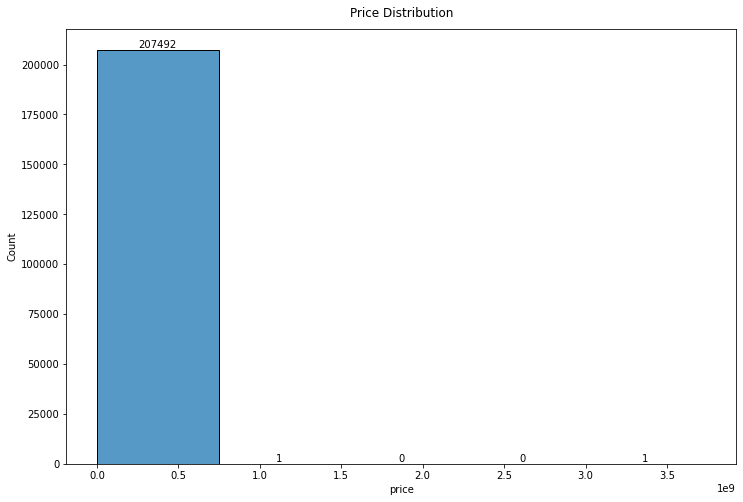

In [8]:
# Looking at the target column "price" first
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Price Distribution', pad=12)
sns.histplot(vehicles_df, x="price", stat='count', bins=5)
show_values_on_bars(ax)

It appears that the price ranges between 0 and an unrealistic $3.7B

To keep things simple and realistic, making a subset of prices between 2k and 50k



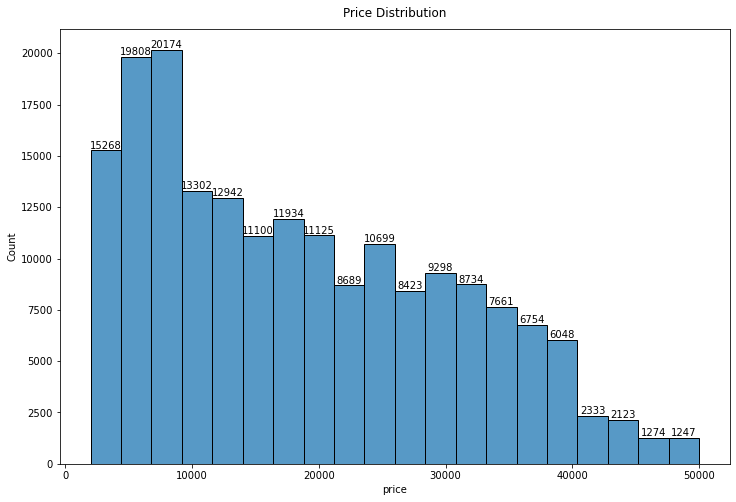

In [9]:
vehicles_prc = vehicles_df[(vehicles_df.price >=2000) & (vehicles_df.price <=50000)]

# Then plot the distriution again
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Price Distribution', pad=12)
sns.histplot(vehicles_prc, x="price", stat='count', bins=20)
show_values_on_bars(ax)

Skewness for odometer: 48.89




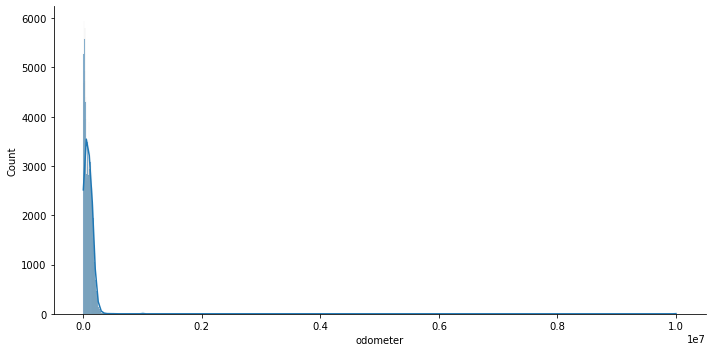

In [10]:
# Check for skewness
print(f"Skewness for odometer: {round(vehicles_prc['odometer'].skew(),2)}\n\n")
sns.displot(data=vehicles_prc, x="odometer", aspect=2, height=5, kde=True)

It's evident that the distribution is highly skewed and there's some bad data with max odometer readings of 10mil miles etc.

Let's work on cleaning up some of that data

Doing some research, I found that Americans drive an average of 14,300 miles per year, according to the Federal Highway Administration.

Let's look at the entries for odometer = 0 and odometer > 200k.

In [11]:
print(vehicles_prc[(vehicles_prc.odometer == 0)].describe())
print('\n')
print(vehicles_prc[(vehicles_prc.odometer > 200000)].describe())

              price  odometer
count    397.000000     397.0
mean   13406.952141       0.0
std     8569.635444       0.0
min     2000.000000       0.0
25%     7500.000000       0.0
50%    10900.000000       0.0
75%    18000.000000       0.0
max    49995.000000       0.0


              price      odometer
count   9549.000000  9.549000e+03
mean    7682.961776  2.948502e+05
std     6031.340132  5.948871e+05
min     2000.000000  2.000040e+05
25%     3650.000000  2.120000e+05
50%     5500.000000  2.280000e+05
75%     9500.000000  2.522690e+05
max    50000.000000  1.000000e+07


Based on the stats above, I can make a fair assumption that odometer readings be between 100 (CPO) to 200k (20 yo) will be a good dataset to continue with

            odometer
count  178321.000000
mean    79480.735825
std     54110.314094
min       101.000000
25%     30237.000000
50%     74000.000000
75%    122000.000000
max    200000.000000


Skewness for odometer: 0.36




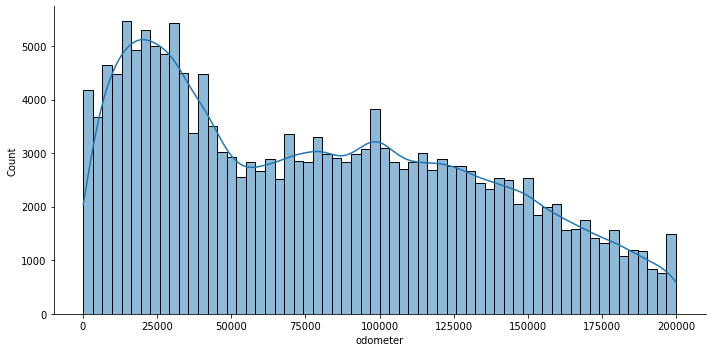

In [12]:
# Filtering the dataset and verifying again
vehicles_odo = vehicles_prc[(vehicles_prc.odometer >100) & (vehicles_prc.odometer <=200000)]

print(pd.DataFrame(vehicles_odo.odometer).describe())

print(f"\n\nSkewness for odometer: {round(vehicles_odo['odometer'].skew(),2)}\n\n")
sns.displot(data=vehicles_odo, x="odometer", aspect=2, height=5, kde=True)


In [13]:
# how the age of cars and the odometer readings are related to the price of cars

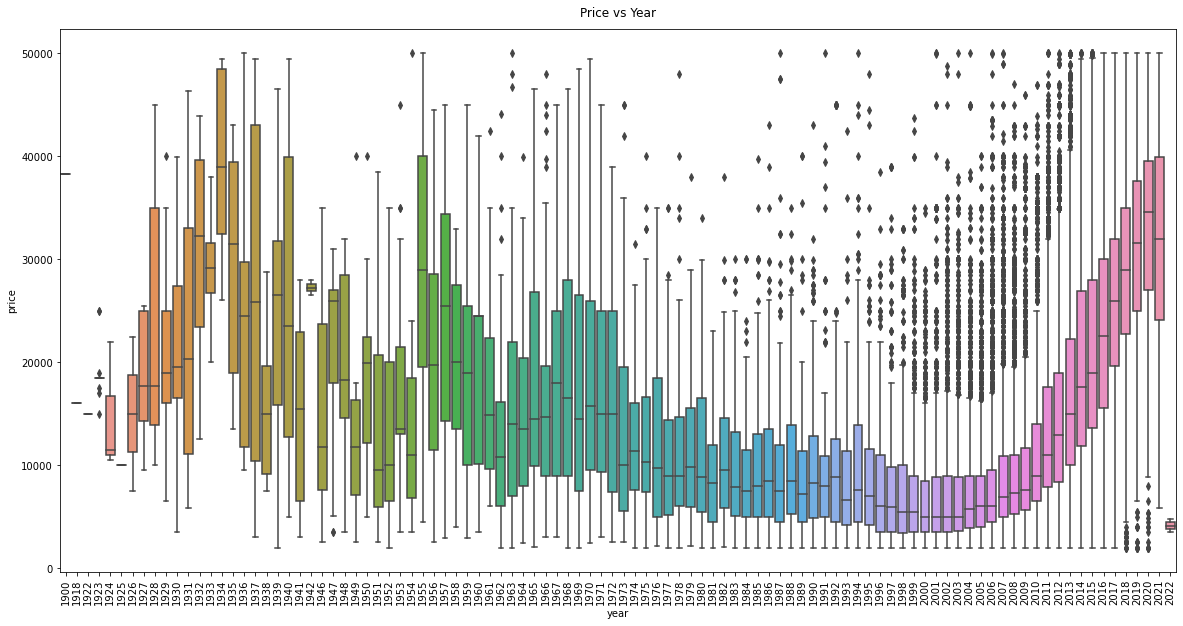

In [14]:
f, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Price vs Year', pad=12)
fig = sns.boxplot(x=vehicles_odo.year.astype(int), y='price', data=vehicles_odo)
plt.xticks(rotation=90);

It appears that there is some inconsistency in the first 2/3rds of the dataset.

Price seems to consistently rise 2000 onwards until about 2021; and there seems to be some bad data for 2022 as well.

Filtering the dataset between 2000 and 2020 for further analysis

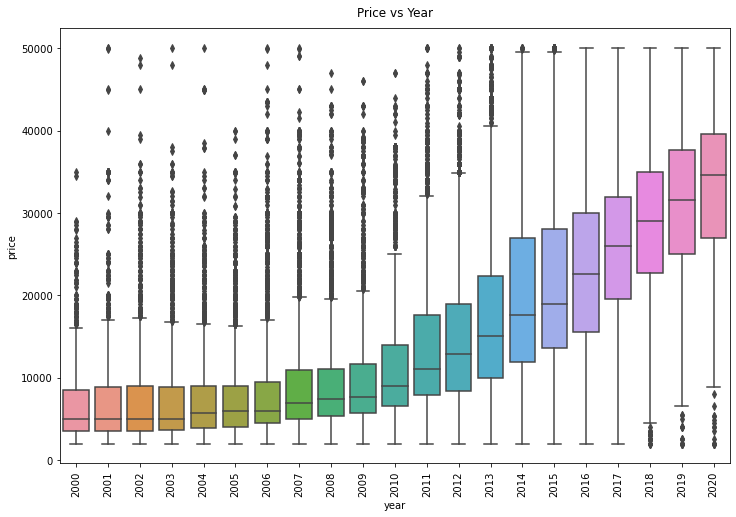

In [15]:
year_list = list(range(2000, 2021))

vehicles_year = vehicles_odo[vehicles_odo.year.astype(int).isin(year_list)]

# Plot again to visualize distribution
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Price vs Year', pad=12)
fig = sns.boxplot(x=vehicles_year.year.astype(int), y='price', data=vehicles_year)
plt.xticks(rotation=90);

With this used 20 year set, next, trying to find how the three features come together and depict real-worl characteristics. Checking how price varies with mean odometer ratings over the age of the car posted

In [16]:
# Calculate age of the posted car using "posting date"
# Convert year and posting date to datetime
vehicles_year.posting_date = pd.to_datetime(vehicles_year.posting_date, utc=True)
vehicles_year.posting_date = vehicles_year.posting_date.astype('datetime64[ns]')

# Add a new field for age of cars
vehicles_year['age'] = vehicles_year.posting_date.dt.year.astype(int) - vehicles_year.year.astype(int)

# Get a preview of the changes
vehicles_year.head()

,price,year,manufacturer,model,condition,fuel,odometer,transmission,type,posting_date,age
0,33590,2014,gmc,sierra 1500 crew cab slt,good,gas,57923.0,other,pickup,2021-05-04 17:31:18,7
1,22590,2010,chevrolet,silverado 1500,good,gas,71229.0,other,pickup,2021-05-04 17:31:08,11
2,39590,2020,chevrolet,silverado 1500 crew,good,gas,19160.0,other,pickup,2021-05-04 17:31:25,1
3,30990,2017,toyota,tundra double cab sr,good,gas,41124.0,other,pickup,2021-05-04 15:41:31,4
4,15000,2013,ford,f-150 xlt,excellent,gas,128000.0,automatic,truck,2021-05-03 19:02:03,8


In [17]:
# Filter the DataFrame to select rows where 'manufacturer' is 'audi'
audi_vehicles = vehicles_year[vehicles_year['manufacturer'] == 'audi']

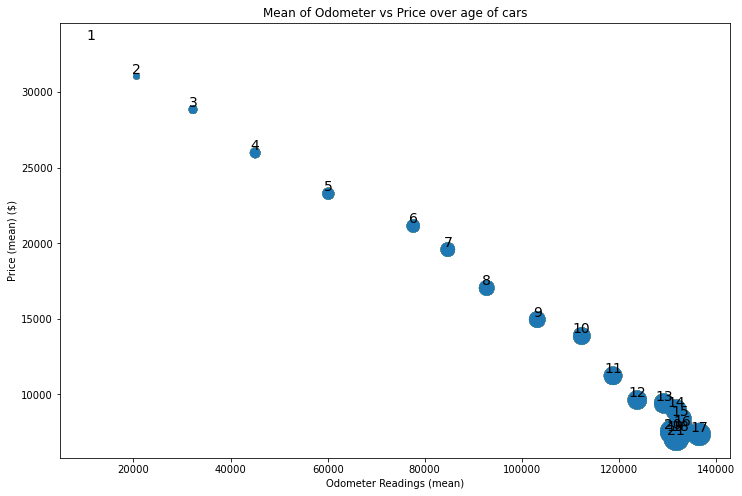

In [18]:
# Get mean of odometer readings by age
grp_df = vehicles_year.groupby(by='age').mean()[['price','odometer']].astype(int).reset_index()

# Visualize how odometer average readings vary with price over age of cars
# Set axes and points 
x = x=grp_df.odometer
y = grp_df.price
points = grp_df.age
s = [30*n for n in range(len(y))]

f, ax = plt.subplots(figsize=(12, 8))
# Plot for each year
plt.title(f"Mean of Odometer vs Price over age of cars")
plt.xlabel("Odometer Readings (mean)")
plt.ylabel("Price (mean) ($)")

# Add labels for weeks
for i, week in enumerate(points):
    plt.annotate(week, (x[i], y[i]), size=14, va="bottom", ha="center")
    plt.scatter(x, y, s=s)


It's evident from the visualization above that cars that have been driven less are more expensive than older cars which have been driven more. There seem to be a good chunk of cars under 10k that have been driven 120k and over and are 12 years and older - this is an interesting insight.

Since we want to look at only used cars, ignoring new cars for the moment.

It also looks like there are only parts being sold - which might affect the price.

Removing both these attributes..

In [19]:
vehicles_used = vehicles_year[vehicles_year.condition != 'new']

In [20]:
# Understanding how price of cars is affected by the fuel and trasmission features...

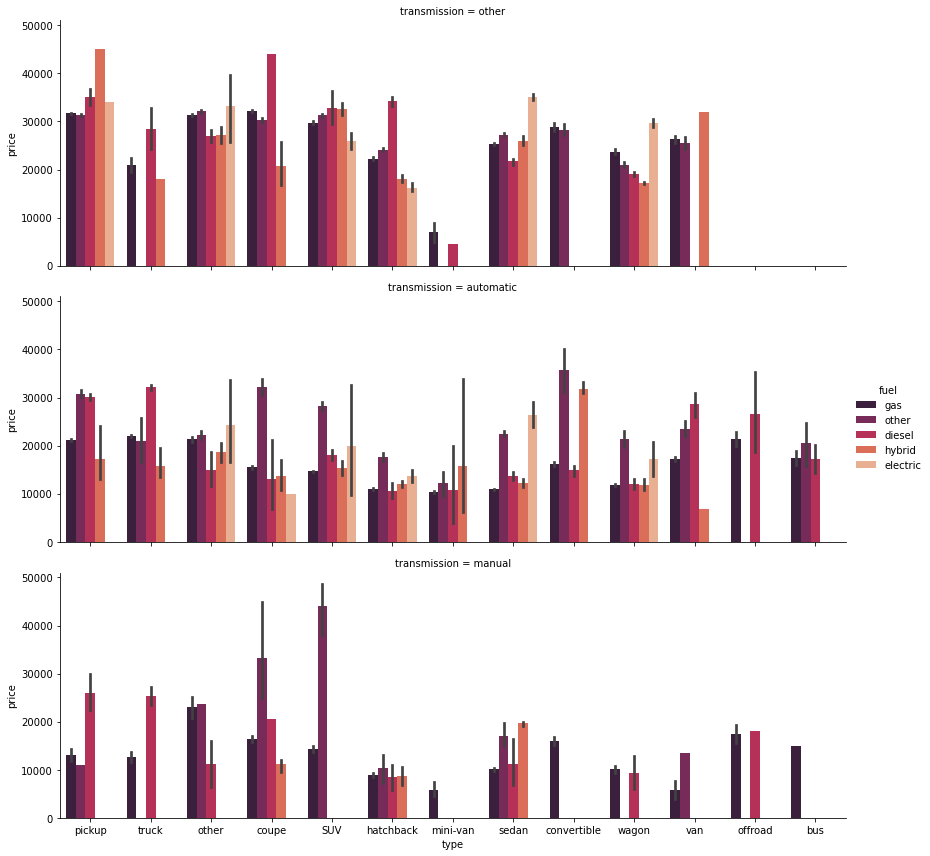

In [21]:
# Categorical plot between fuel and price for each type of trasmission 
sns.catplot(x='type', y ='price', hue='fuel', col='transmission', data=vehicles_used, kind="bar", 
            aspect=3, height=4,  palette="rocket", col_wrap=1)

From the above visualization, it's noted that "other" values for type of fuels and trasmissions contribute to a considerable volume of data.

These, which are not a lot of value might affect the overall accuracy - hence removing them..

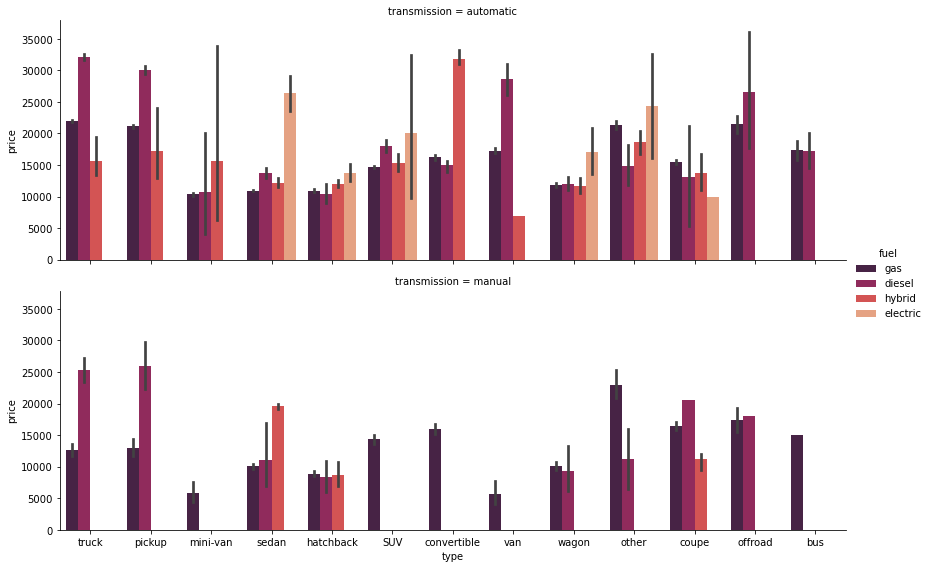

In [22]:
# Remove "other" types of fuel
vehicles_used = vehicles_used[(vehicles_used.fuel != 'other')]

# Remove "other" type of trasmissions
vehicles_used = vehicles_used[(vehicles_used.transmission != 'other')]

# Plot again to visualize
sns.catplot(x='type', y ='price', hue='fuel', col='transmission', data=vehicles_used, kind="bar", 
            aspect=3, height=4,  palette="rocket", col_wrap=1)

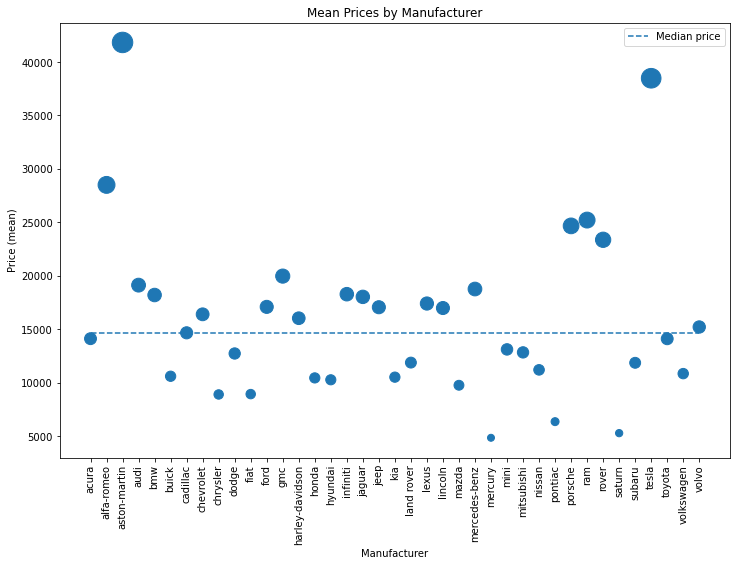

In [23]:
# Visualize the relationship of average price by manufacturer
grp_man_df = vehicles_used.groupby(by='manufacturer').mean()['price'].reset_index()

x = grp_man_df.manufacturer
y = grp_man_df.price
y_mean = [np.median(y)]*len(grp_man_df)


f, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y, s=y/100)
ax.plot(x, y_mean, label='Median price', linestyle='--')

plt.title(f"Mean Prices by Manufacturer")
plt.ylabel("Price (mean)")
plt.xlabel("Manufacturer")
plt.xticks(rotation=90)
plt.legend()
plt.show()

It's obviously evident that luxury brands have a higer price, but except a couple outliers, the median price lies near most points

Finally, we explore the "model" feature which I imagine has the highest cardinality amongst all the features we've seen so far..

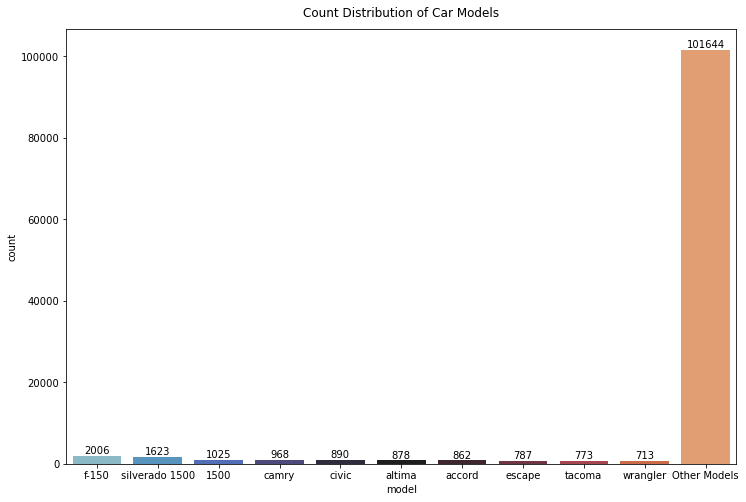

In [24]:
vehicles_used['row_num'] = np.arange(len(vehicles_used))

# Get counts of models
model_df = vehicles_used.groupby(by="model").count()['row_num'].reset_index()
model_df.columns=(['model','count'])

# Get only 10 frequent models and how much the other account to
lar10_df = model_df.nlargest(10, columns='count')
lar10_df.index = range(len(lar10_df))

# Get count of all other models and append to the end of data drame
other_val_sum = model_df[~model_df['model'].isin(lar10_df.model)].sum().T['count']
lar10_df.loc[10] = ['Other Models',other_val_sum]

# Plot what the counts of models look like
f, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Count Distribution of Car Models', pad=12)
sns.barplot(x="model", y="count",  palette="icefire",  data=lar10_df)
show_values_on_bars(ax)

As noted above, the "model" field has very high cardinality and this would have to be encoded with one of the encoders as they describe in this (slightly older) article

I do want to note here that I want to experiment without dropping this high cardinality feature and work with models - if the accuracy turns to be too low, it's worth exploring without this feature

In [25]:
# # Filter vehicles that are not more than 6 years old
# filtered_df = vehicles_used_enc[vehicles_used_enc['age'] <= 6]
# filtered_df

# Encoding Categorical Data

Since almost all features are categorical in this dataset, we'd have to encode them. I use Label Encoding

In [26]:
# Get current information of the dataset
vehicles_used.info()

# Drop columns populated during clean-up or not required
vehicles_used.drop(columns=['posting_date','row_num'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112169 entries, 4 to 207488
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   price         112169 non-null  int64         
 1   year          112169 non-null  object        
 2   manufacturer  112169 non-null  object        
 3   model         112169 non-null  object        
 4   condition     112169 non-null  object        
 5   fuel          112169 non-null  object        
 6   odometer      112169 non-null  float64       
 7   transmission  112169 non-null  object        
 8   type          112169 non-null  object        
 9   posting_date  112169 non-null  datetime64[ns]
 10  age           112169 non-null  int64         
 11  row_num       112169 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 11.1+ MB


In [27]:
# Make a copy of the data frame for encoding
vehicles_used_enc = vehicles_used.copy()
vehicles_used_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112169 entries, 4 to 207488
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         112169 non-null  int64  
 1   year          112169 non-null  object 
 2   manufacturer  112169 non-null  object 
 3   model         112169 non-null  object 
 4   condition     112169 non-null  object 
 5   fuel          112169 non-null  object 
 6   odometer      112169 non-null  float64
 7   transmission  112169 non-null  object 
 8   type          112169 non-null  object 
 9   age           112169 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 9.4+ MB


In [28]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Preparing Data and Modeling

In [32]:
feature_cols = vehicles_used_enc.columns.values.tolist()
feature_cols.remove('price')
feature_cols.remove('transmission')
feature_cols.remove('type')
feature_cols.remove('fuel')
X = vehicles_used_enc[feature_cols]
Y = vehicles_used_enc['price']


In [35]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)

In [36]:
# Specify the categories for each categorical feature
categories = [x_train['manufacturer'].unique(), x_train['model'].unique(), x_train['condition'].unique()]

In [37]:
# Create a OneHotEncoder with specified categories
oh = OneHotEncoder(categories=categories, handle_unknown='ignore')

# Create a ColumnTransformer
column_trans = make_column_transformer(
    (oh, ['manufacturer', 'model', 'condition']), 
    remainder='passthrough'
)

In [38]:
# Create a Random Forest Regressor
rf_reg = RandomForestRegressor()

In [39]:
# Create a Pipeline
pipe = make_pipeline(column_trans, rf_reg)

In [40]:
# Fit the pipeline
pipe.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['bmw', 'toyota', 'ford', 'gmc', 'chevrolet', 'jeep', 'honda',
       'subaru', 'mercedes-benz', 'dodge', 'hyundai', 'volkswagen',
       'rover', 'lexus', 'audi', 'saturn', 'nissan', 'mini', 'chrysler',
       'volvo', 'lincoln', 'buick', 'kia', 'acur...
       'alfa-romeo', 'land rover', 'aston-martin'], dtype=object),
                                                                            array(['750li', 'rav4 limited', 'escape se', ...,
       'outback wagon limited 1 owner nice!!', '1500 crew cab 4x4',
       'gr caravan hero'], dtype=object),
                                                                            array(['excellent', 'like new', 'good', 'fair', 'salvage'], dtype=object)],
                                          

In [41]:
# Make predictions
y_pred = pipe.predict(x_test)

# Evaluate the model as needed
# For example, you can calculate the R-squared score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared Score: {r2}")

R-squared Score: 0.8410408833454441


In [51]:
# Create a DataFrame with column names
x = pd.DataFrame([[2022, "acura", "ILX", "excellent", 33000.0, 2]],
                 columns=["year", "manufacturer", "model", "condition", "odometer", "age"])

# Use the pipeline to predict the price
predicted_price = pipe.predict(x)

# Print the predicted price
print(f"Predicted Price: {predicted_price[0]}")

Predicted Price: 30546.64666666667


In [53]:
import pickle

In [54]:
pickle.dump(pipe, open('RandomForestRegressionModel.pkl', 'wb'))

In [43]:
#########################